In [65]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import copy
import os
from statsmodels.tsa.arima.model import ARIMA

%run ../CTD/util.ipynb
%run ../CTD/CTD.ipynb
%run ../CTD/data_generator.ipynb

In [66]:
dataset_idx=15
diff=1
K = 5
M = 4
N = 1000
l_max = 6
T = 300
T_future = 5
lambda_rate = (M * (N + T) * np.log(N + T))/ (N * T)

AR_params = [[ 0., -0.5,  0.2,  0.,  0.2,  0.,   0.],
             [0.,  0.3,  -0.1,  0., 0,  0., 0.],
             [0., 0,   0,  0,  0.,  0.,  -0.6],
             [ 0., -0.05,   0.,   0., -0.4,  0.,  0.0],
             [0.,   0.2,  0.02, 0.2,  0.2,   0., 0.0],
             [0.,  0.1,  0. ,  0., 0.,    -.5,   -.1],
             [0.,  0.,  0.2,  0.5,  0.,  0., -0.],
            ]

centers = np.array([[0.,  1., 0.0,  1.],
                   [0.,  0., 2.,  1.],
                   [0., -1., 0.,  -1.],
                   [1.,  .0, -0.0, -1.],
                   [-1., -.0, -0.0,  0.]])

sigmas = (1/5) * np.array([[0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.]])

# Select one of 16 cases

In [68]:
# Component 1: observational noise
Z_sd = 5. # Large noise
#Z_sd = 3. # Small noise

# Component 2: missing entries
#p_missing = 0.05 # 5% of entries missing 
p_missing = 0.00 # No missing entries

# Component 3: dimensional imbalance
#Small - keep current
#sigmas[:,2:] = (2/5) #large

# Component 4: Cluster distances
#close together - keep current
centers *= 5; sigmas *= 5 #Far away

Above gives a dataset with larger observational noise, no missing entries, higher dimensional balance among columns of $X^*$, and large cluster distances relative to size of the temporal embedding.

In [69]:
data = Simulate(N=N,T=T+T_future, K=K, M=M, 
           tmp_params=(np.array(AR_params)[:M,:].T), 
           centers=centers,
           Z_sd=Z_sd,
           Sigmas=sigmas,
           p_missing=p_missing,
           cluster_props=None,
           W=1,
           D=diff,
           seed=dataset_idx,
           torch_device='cuda:0')
data.generate()

data.Z_star = data.X.mm(data.Y.T)
data_np = data.Z_obs.detach().cpu().numpy()
data_pd = pd.DataFrame(data_np)
true_labels_pd = pd.DataFrame(data.labels)

X, Y, mask, Z, Z_obs generated
All objects converted to torch tensor


# Exploration of $X^*, Y^*,$ and $Z^*$

## 1) Pairwise scatter plots of $X^*$

<Figure size 640x480 with 0 Axes>

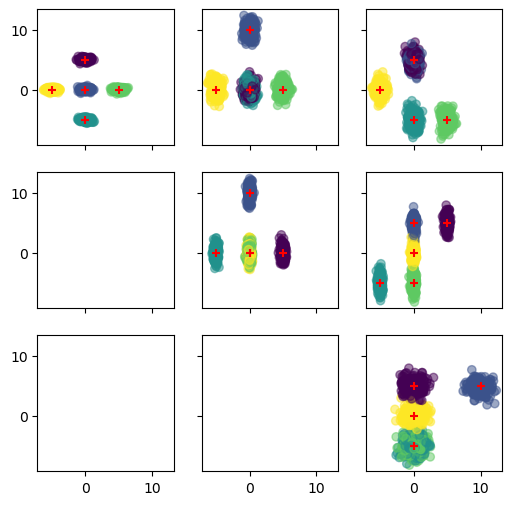

In [70]:
plt.clf()
X_np = data.X.detach().cpu().numpy()
new_centers = data.centers.detach().cpu().numpy()
fig, axes = plt.subplots(M-1, M-1, figsize=(6,6),
                        sharex=True, sharey=True)
for m1 in range(M):
    for m2 in range(M):
        if m1 < m2:
            axes[m1,m2-1].scatter(X_np[:,m1],X_np[:,m2], 
                                  c=data.labels, alpha=0.5)
            axes[m1,m2-1].scatter(new_centers[:,m1],new_centers[:,m2], 
                          color="red", marker="+")
plt.show()

<Figure size 640x480 with 0 Axes>

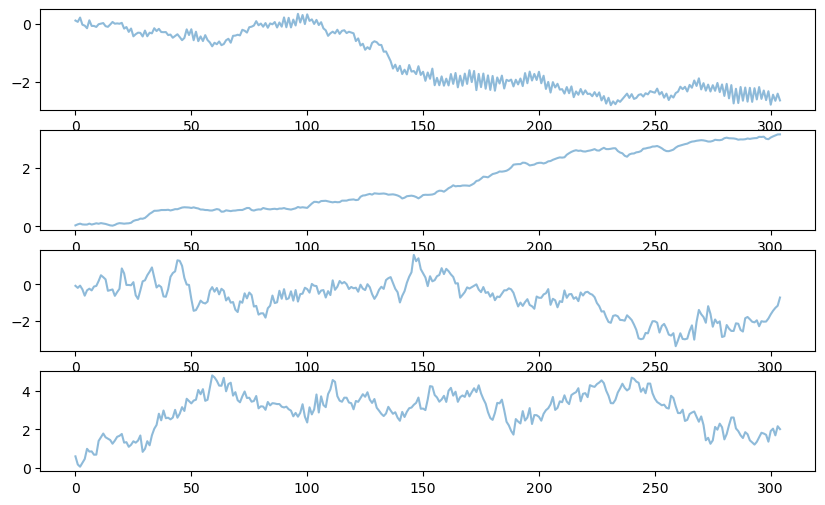

In [71]:
plt.clf()
fig,axes = plt.subplots(M, figsize=(10,6),sharey=False)
for m in range(M):
    axes[m].plot(data.Y[:,m].detach().cpu().numpy(), alpha=0.5)
plt.show()

# Run

In [72]:
fitter = CTD(Z_obs = data.Z_obs[:,:T],
                     AR_lags=torch.arange(l_max) + 1, 
                     difference=diff,
                     K = K, 
                     M = M,
                     lambda_x = 0.001 * lambda_rate,
                     lambda_y = 0.001 * lambda_rate,
                     iter_per_message=50,
                     seed=dataset_idx,
                     lr=0.003) 
fitter.fit(noise=0.5)

##################################
Pretraining begins
##################################
Loop 2348 | pretrain loss 24.684200699393255
X singular values: tensor([141.7730,  79.6760,  36.5235,  20.4651], device='cuda:0')
#####################################
Pretraining is finished
#####################################
Loop 50 | overall_loss 31.5055 | x 0.0005 | y 0.0003 
_________________________
Loop 100 | overall_loss 27.7328 | x 0.0004 | y 0.0002 
_________________________
Loop 150 | overall_loss 26.0314 | x 0.0004 | y 0.0002 
_________________________
Loop 200 | overall_loss 25.2895 | x 0.0004 | y 0.0001 
_________________________
Loop 250 | overall_loss 24.9645 | x 0.0003 | y 0.0001 
_________________________
Loop 300 | overall_loss 24.8257 | x 0.0003 | y 0.0001 
_________________________
Loop 350 | overall_loss 24.7861 | x 0.0002 | y 0.0001 
_________________________
Training finished


# Loss trajectories over iterations

<Figure size 640x480 with 0 Axes>

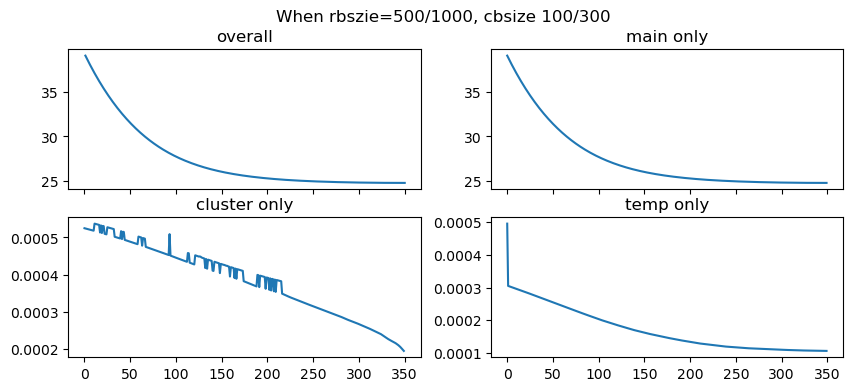

In [73]:
#lambdas 0.1 and lr 0.001 (or 0.01)
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(10,4), sharex=True)
axes[0,0].plot(np.array(fitter.overall_losses))
axes[0,0].set_title("overall")
axes[0,1].plot(np.array(fitter.overall_losses[1:])-np.array(fitter.cluster_regs))
axes[0,1].set_title("main only")
axes[1,0].plot(np.array(fitter.cluster_regs))
axes[1,0].set_title("cluster only")
axes[1,1].plot(np.array(fitter.temporal_regs))
axes[1,1].set_title("temp only")
fig.suptitle("When rbszie=500/1000, cbsize 100/300")
plt.show()

# View results
## 1) Cluster result

In [74]:
c_results = compute_cluster_baseline(data.Z_obs[:,:T], M, data.labels, 
                                     seed=dataset_idx, save_to=None)
c_results['CTD'] = fitter.compute_cluster_error(data.labels)  
c_results

computing result for PCA MG


,datetime,dataset_idx,pca_GM,CTD
0,2024-12-11 19:26:34,15,0.305565,0.005002


<Figure size 640x480 with 0 Axes>

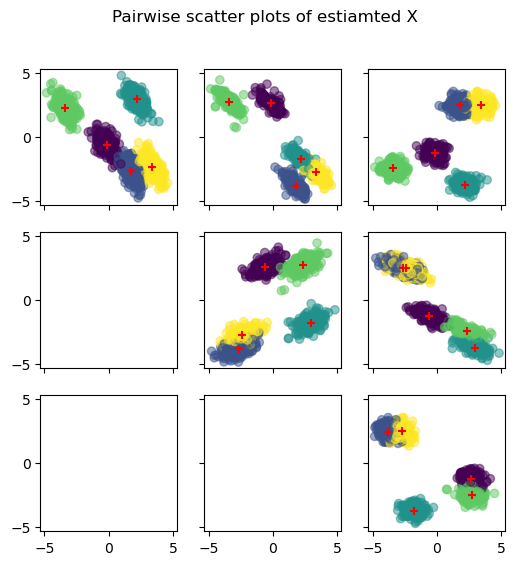

In [75]:
hard_labels =fitter.soft_labels.argmax(dim=1).detach().cpu().numpy()
plt.clf()
X_np = fitter.X.detach().cpu().numpy()
new_centers = fitter.centers.detach().cpu().numpy()
fig, axes = plt.subplots(M-1, M-1, figsize=(6,6),
                        sharex=True, sharey=True)
for m1 in range(M):
    for m2 in range(M):
        if m1 < m2:
            axes[m1,m2-1].scatter(X_np[:,m1],X_np[:,m2], 
                                  c=hard_labels, alpha=0.5)
            axes[m1,m2-1].scatter(new_centers[:,m1],new_centers[:,m2], 
                          color="red", marker="+")
plt.suptitle("Pairwise scatter plots of estiamted X")
plt.show()

# Forecast error

In [78]:
hist_pred = fitter.Z_hat().detach().cpu().numpy()
alg_future = fitter.predict(T_future).detach().cpu().numpy()
compute_est_performance(pred=alg_future[:,:T_future], 
                         truth=data.Z_star[:, T:T+T_future], 
                         history=data.Z_star[:, :T],
                         method_name="CTD_forecast",
                         dataset_idx=dataset_idx,
                         types=["NRMSE", "SMAPE"],
                         save_to=None)

,method,datetime,dataset_idx,NRMSE,SMAPE
0,CTD_forecast,2024-12-11 19:27:05,15,0.239789,0.331303


# History estimation error

In [79]:
compute_est_performance(pred=hist_pred, 
                         truth=data.Z_star[:, :T], 
                         history=data.Z_star[:, :T],
                         method_name="CTD_history",
                         dataset_idx=dataset_idx,
                         types=["NRMSE", "SMAPE"],
                         save_to=None)

,method,datetime,dataset_idx,NRMSE,SMAPE
0,CTD_history,2024-12-11 19:27:23,15,0.031954,0.079821
